# Определение возраста покупателей

Внедрение системы компьютерного зрения для обработки  фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать  покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Ниже указана модель, которая по фотографии определит приблизительный возраст человека. в качестве примера опеределен набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Found 7591 validated image filenames.


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


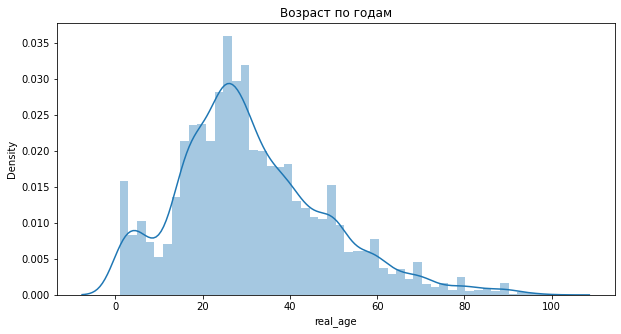

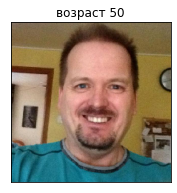

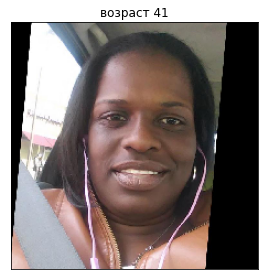

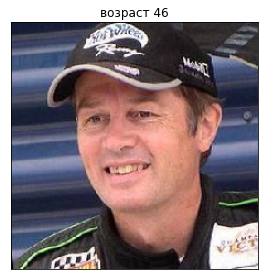

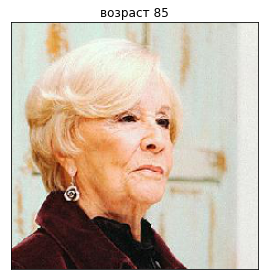

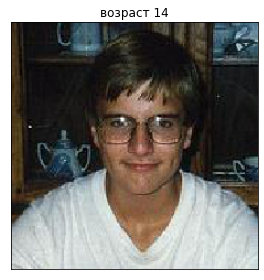

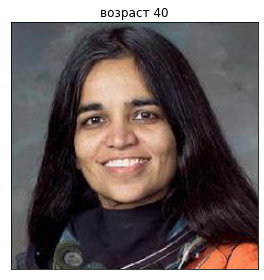

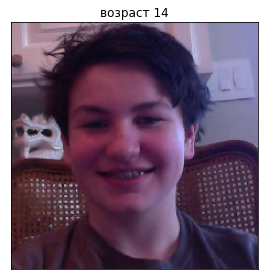

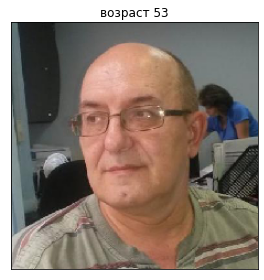

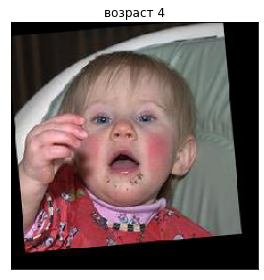

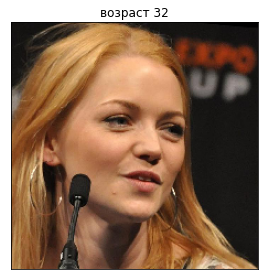

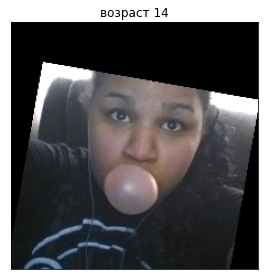

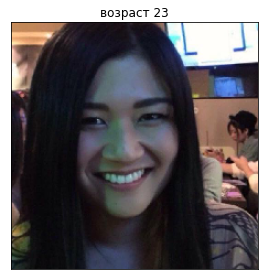

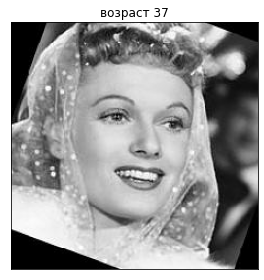

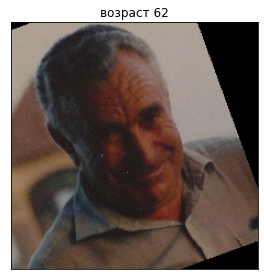

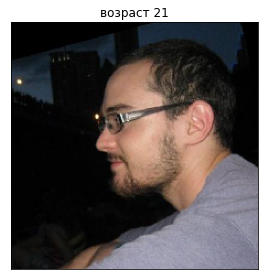

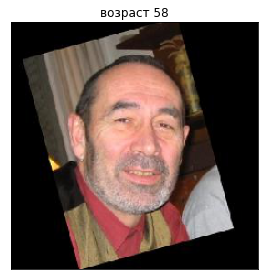

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

labels.describe()

plt.figure(figsize=(10,5))
sns.distplot(labels.real_age,  bins=50)
plt.title('Возраст по годам')
plt.show()

features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

Вывод 
    1. нет выбросов, распределение возрастов достаточно плавное 
    2. на фото встречаются не четкие изображения, разные яркости, не централизованные, фас/профиль, головные уборы. Эти факторы будут увеличивать ошибку, но при этм помогут модели не переобучится
    + добавлю
    3. на графике видны пики в значениях кратные 5и, видимо имеет место быть округления
    4. большинство фотографий располодены в диапазоне возраста с 15и до 50 и максимум с 20 до 30 

## Обучение модели

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 

    


In [3]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow
 

 

In [4]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    return test_gen_flow
 
   
 


In [8]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

## Анализ обученной модели

1. Исследовательский анализ данных: представлены к анализу 7591 фото разного качества (много повернутых изображений по горизонтали, размытые изображения, с головными уборами и без, фа/профиль и прочее)  и с достаточно плавным распределением возрастов,  этого достаточно что бы провести обучение  модели без заморозки основного слоя сети. 
2. Обученая модель на архитерткуре ResNet50 показала требуемую точность уже на 2й эпохе. при этом использовался оптимизатор adam c шагом в 0.0001.
после 4й эпохи уже пошло переобучение, так что в целом можно использовать модель с указанными параметрами с 2мя эпохами